# Simulated Spike: Helper setup

In [1]:
import timesynth as ts
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from scipy.signal import butter, lfilter, freqz
import pickle as pkl
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from tqdm import tqdm


KeyboardInterrupt: 

In [2]:

def generate_sample(plot, Tt=80):
    trend_style='hill'
    noise = ts.noise.GaussianNoise(std=0.001)
    x1 = ts.signals.NARMA(order=2,coefficients=[.5,.5,1.5,.5],seed=random.seed())
    x1_ts = ts.TimeSeries(x1, noise_generator=noise)
    x1_sample, signals, errors = x1_ts.sample(np.array(range(Tt)))
    x1_sample += 0.003*np.array(range(Tt)) 
    x1_sample = x1_sample/(max(x1_sample)-min(x1_sample)) # - 1
    
    noise = ts.noise.GaussianNoise(std=0.001)
    x2 = ts.signals.NARMA(order=2,coefficients=[.5,.5,1.5,.5],seed=random.seed())
    x2_ts = ts.TimeSeries(x2,noise_generator=noise)
    x2_sample,signals,errors = x2_ts.sample(np.array(range(Tt)))
    x2_sample += 0.065*np.array(range(Tt)) 
    x2_sample /=(max(x2_sample)-min(x2_sample))
    
    noise = ts.noise.GaussianNoise(std=0.001)
    x3 = ts.signals.NARMA(order=2,seed=random.seed())
    x3_ts = ts.TimeSeries(x3, noise_generator=noise)
    x3_sample, signals, errors = x3_ts.sample(np.array(range(Tt)))
    x3_sample = x3_sample/(max(x3_sample)-min(x3_sample)) - 0.5
    
    t = np.array(np.zeros(4))
    
    return np.stack([x1_sample, x2_sample, x3_sample]), t, trend_style


def save_data(path,array):
    with open(path,'wb') as f:
        pkl.dump(array, f)


def logistic(x):
    return 1./(1+np.exp(-1*x))

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Main

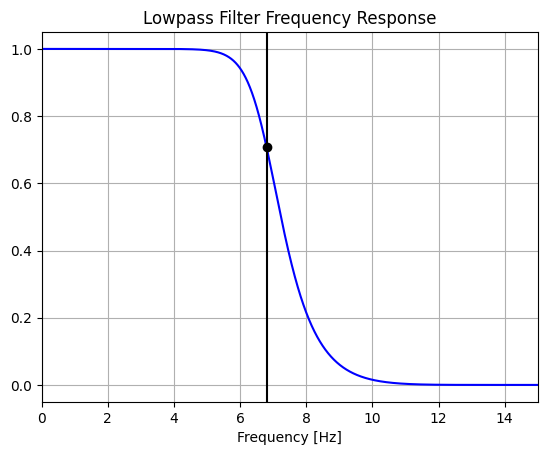

In [3]:

# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 6.8 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

w, h = freqz(b, a, worN=8000)
plt.subplot(1, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()



n_samples = 3000
Tt = 80
plot = True

In [4]:

signal_in = []
thresholds = []
trend_style = []
for i in range(n_samples):
    x,t,trend = generate_sample(plot, Tt=Tt)
    signal_in.append(x)
    thresholds.append(t)
    trend_style.append(trend)

print('samples done!')
signal_in = np.array(signal_in)

n_train = int(0.8*n_samples)
x_train = signal_in[0:n_train,:,:]
thresholds_train = thresholds[0:n_train]
n_test = n_samples - n_train

x_test = signal_in[n_train:,:,:]
thresholds_test = thresholds[n_train:]


samples done!


In [9]:
thresholds

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 

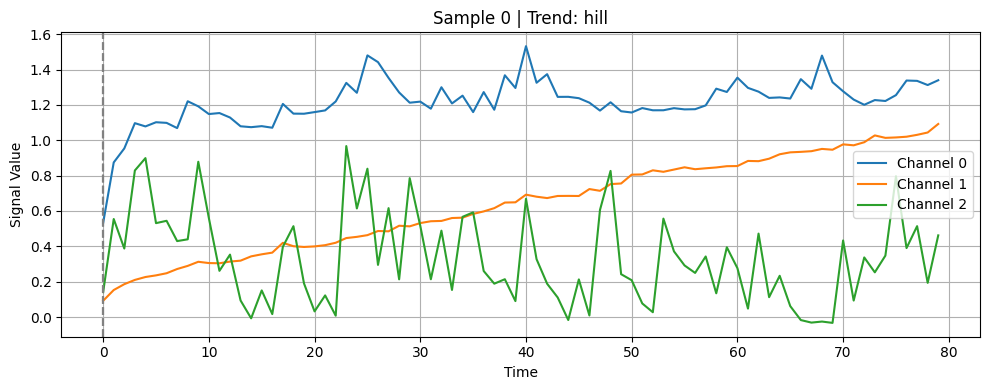

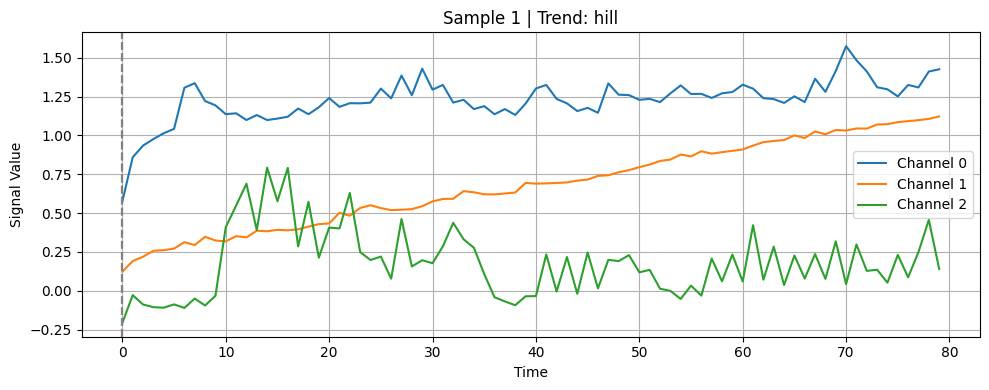

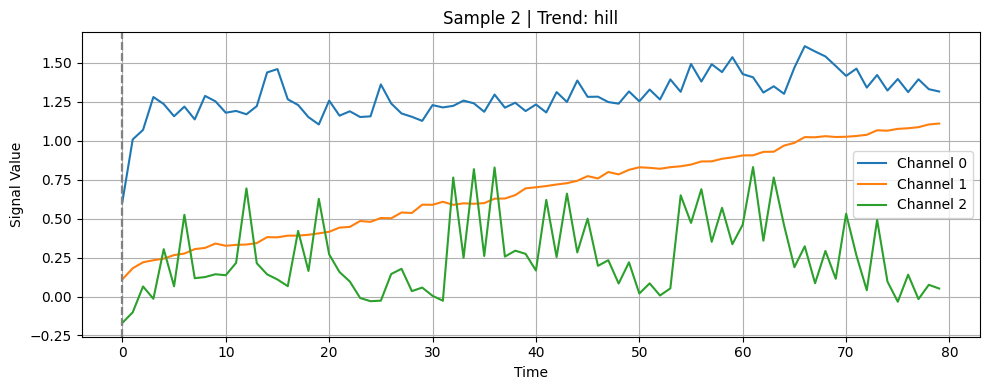

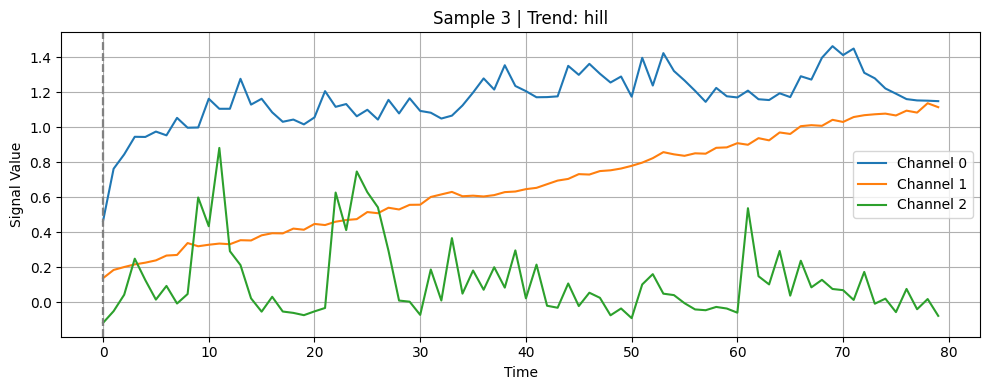

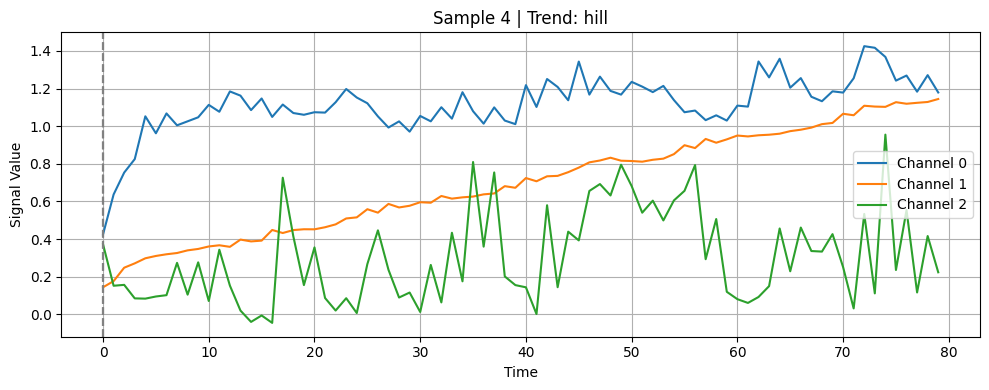

In [5]:
import matplotlib.pyplot as plt

def plot_sample_set(x_data, thresholds, trend_styles, num_to_plot=5):
    T = x_data.shape[2]
    for i in range(min(num_to_plot, len(x_data))):
        plt.figure(figsize=(10, 4))
        for ch in range(3):
            plt.plot(x_data[i, ch], label=f"Channel {ch}")
        if isinstance(thresholds[i], np.ndarray):
            for thresh in thresholds[i]:
                plt.axvline(thresh, color="gray", linestyle="--", alpha=0.6)
        else:
            plt.axvline(thresholds[i], color="gray", linestyle="--", alpha=0.6)
        plt.title(f"Sample {i} | Trend: {trend_styles[i]}")
        plt.xlabel("Time")
        plt.ylabel("Signal Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_sample_set(x_train, thresholds_train, trend_style, num_to_plot=5)


In [6]:
if 0:
    scaler = MinMaxScaler()
    x_train_flat = scaler.fit_transform(np.reshape(x_train,[x_train.shape[0],-1]))
    x_train_n = np.reshape(x_train_flat,x_train.shape)
    x_test_flat = scaler.transform(np.reshape(x_test,[x_test.shape[0],-1]))
    x_test_n = np.reshape(x_test_flat,x_test.shape)
else:
    x_train_n = x_train
    x_test_n = x_test
    
if 1:
    x1_train_lpf = np.array([butter_lowpass_filter(x[0,:], cutoff, fs, order) for x in x_train_n])
    x2_train_lpf = np.array([butter_lowpass_filter(x[1,:], cutoff, fs, order) for x in x_train_n])
    x3_train_lpf = np.array([butter_lowpass_filter(x[2,:], cutoff, fs, order) for x in x_train_n])
    x_train_n = np.stack([x1_train_lpf, x2_train_lpf, x3_train_lpf],axis=1)

    x1_test_lpf = np.array([butter_lowpass_filter(x[0,:], cutoff, fs, order) for x in x_test_n])
    x2_test_lpf = np.array([butter_lowpass_filter(x[1,:], cutoff, fs, order) for x in x_test_n])
    x3_test_lpf = np.array([butter_lowpass_filter(x[2,:], cutoff, fs, order) for x in x_test_n])
    x_test_n = np.stack([x1_test_lpf, x2_test_lpf, x3_test_lpf],axis=1)


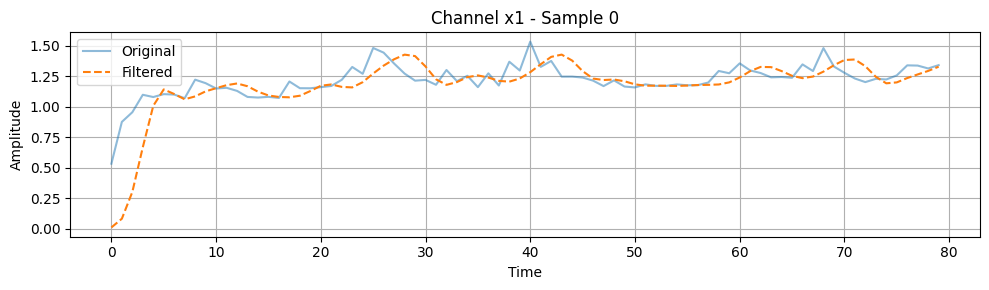

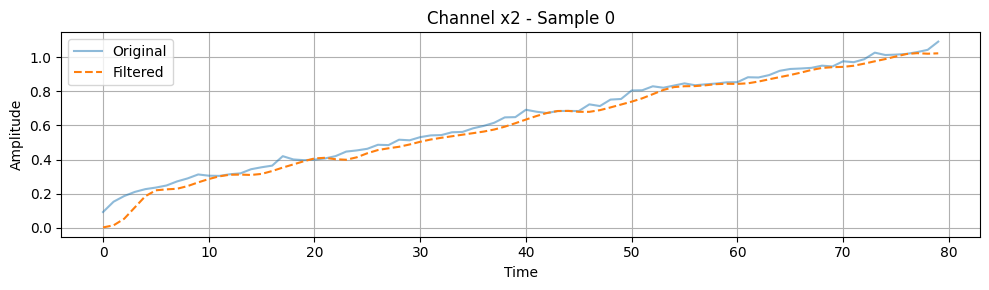

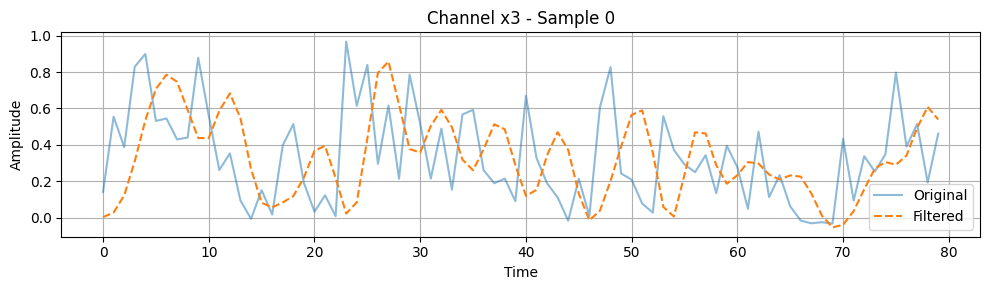

In [7]:
def plot_filter_effect(x_orig, x_filt, sample_idx=0):
    channels = ['x1', 'x2', 'x3']
    T = x_orig.shape[2]
    for ch in range(3):
        plt.figure(figsize=(10, 3))
        plt.plot(range(T), x_orig[sample_idx, ch], label='Original', alpha=0.5)
        plt.plot(range(T), x_filt[sample_idx, ch], label='Filtered', linestyle='--')
        plt.title(f"Channel {channels[ch]} - Sample {sample_idx}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_filter_effect(x_train, x_train_n, sample_idx=0)


In [8]:

kappa=1.5
y_train = []
ground_truth_importance_train=[]
ground_truth_importance_test=[]
pvec=[0.7,0.3]
lamda_poisson = 3

# Train data spike injection with progress bar
for i in tqdm(range(n_train), desc="Injecting spikes into training data"):
    gt_t = np.zeros((Tt))
    add_spikes = np.random.choice([0, 1], 1, p=pvec)
    if add_spikes:
        nts = np.random.poisson(lamda_poisson, 1)
    else:
        nts = 0
    t_vec = np.sort(np.random.choice(range(Tt), nts, replace=False))
    x_train_n[i, 0, t_vec] += kappa
    if len(t_vec) > 0:
        gt_t[t_vec[0]] = 1

    y_vec = np.zeros((Tt))
    if len(t_vec) > 0:
        y_vec[t_vec[0]:] = 1
    y_train.append(y_vec)
    ground_truth_importance_train.append(gt_t)

    for ch in [1, 2]:
        add_spikes = np.random.choice([0, 1], 1, p=pvec)
        if add_spikes:
            nts = np.random.poisson(lamda_poisson, 1)
        else:
            nts = 0
        t = np.random.choice(range(Tt), nts, replace=False)
        if len(t) > 0:
            x_train_n[i, ch, t] += kappa

# Test data spike injection
y_test = []
for i in tqdm(range(n_test), desc="Injecting spikes into test data"):
    gt_t = np.zeros((Tt))
    add_spikes = np.random.choice([0, 1], 1, p=pvec)
    if add_spikes:
        nts = np.random.poisson(lamda_poisson, 1)
    else:
        nts = 0
    t_vec = np.sort(np.random.choice(range(Tt), nts, replace=False))
    if len(t_vec) > 0:
        x_test_n[i, 0, t_vec] += kappa
        gt_t[t_vec[0]] = 1

    y_vec = np.zeros((Tt))
    if len(t_vec) > 0:
        y_vec[t_vec[0]:] = 1
    y_test.append(y_vec)
    ground_truth_importance_test.append(gt_t)

    for ch in [1, 2]:
        add_spikes = np.random.choice([0, 1], 1, p=pvec)
        if add_spikes:
            nts = np.random.poisson(lamda_poisson, 1)
        else:
            nts = 0
        t = np.random.choice(range(Tt), nts, replace=False)
        if len(t) > 0:
            x_test_n[i, ch, t] += kappa

# Convert to arrays
y_train = np.array(y_train)
y_test = np.array(y_test)
ground_truth_importance_train = np.array(ground_truth_importance_train)
ground_truth_importance_test = np.array(ground_truth_importance_test)



Injecting spikes into training data:   0%|          | 0/2400 [00:00<?, ?it/s]

Injecting spikes into test data: 100%|██████████| 600/600 [00:00<00:00, 3592.87it/s]


/tmp/ipykernel_28327/3892273807.py:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i].stem(ground_truth_importance_train[idx], linefmt='r-', markerfmt='ro', basefmt=" ", label='GT Importance', use_line_collection=True)


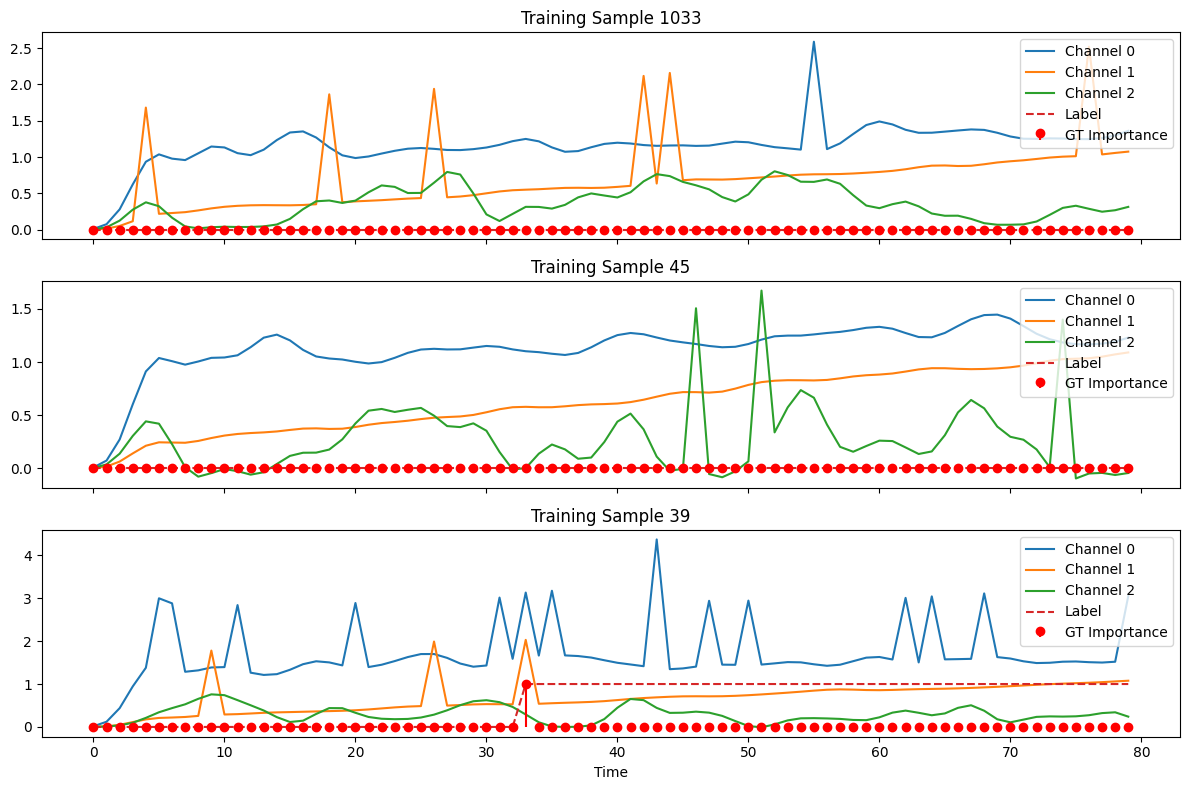

In [17]:
# Plot few samples for visualization
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i in range(3):
    idx = np.random.randint(0, n_train)
    axs[i].plot(x_train_n[idx, 0, :], label='Channel 0')
    axs[i].plot(x_train_n[idx, 1, :], label='Channel 1')
    axs[i].plot(x_train_n[idx, 2, :], label='Channel 2')
    axs[i].plot(y_train[idx], label='Label', linestyle='--')
    axs[i].stem(ground_truth_importance_train[idx], linefmt='r-', markerfmt='ro', basefmt=" ", label='GT Importance', use_line_collection=True)
    axs[i].legend(loc='upper right')
    axs[i].set_title(f"Training Sample {idx}")
axs[2].set_xlabel("Time")
plt.tight_layout()
plt.show()

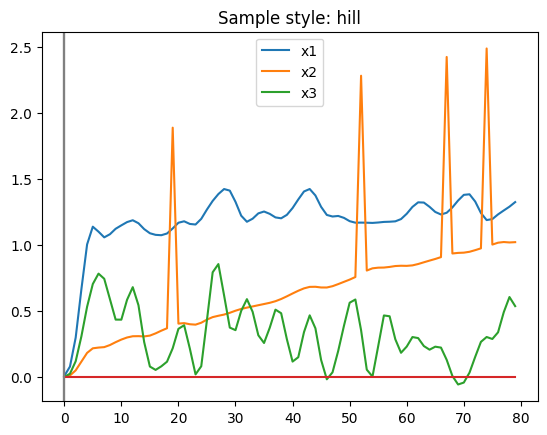

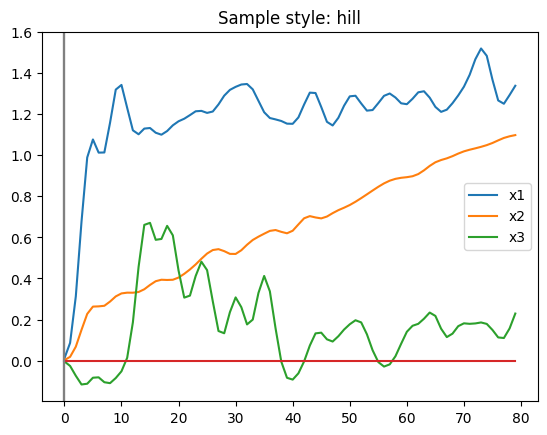

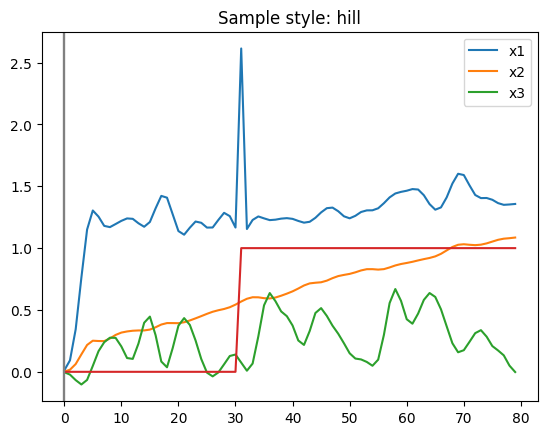

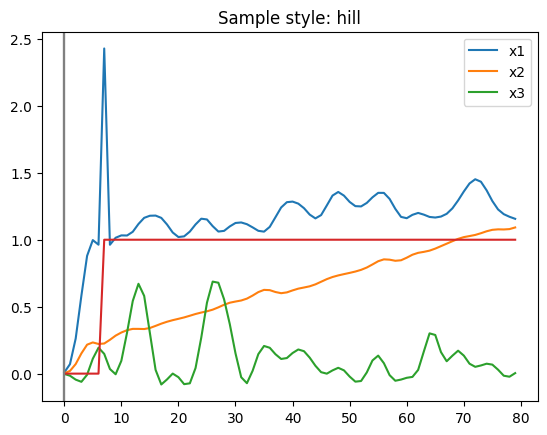

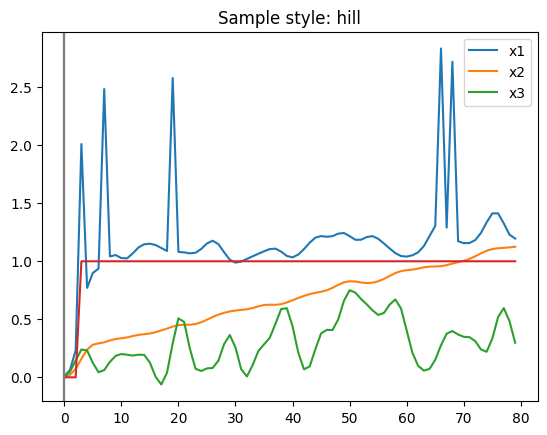

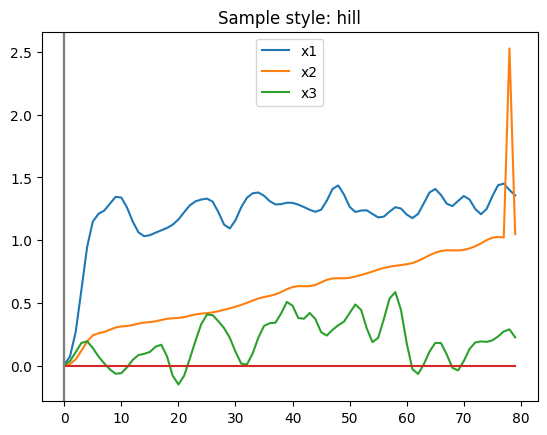

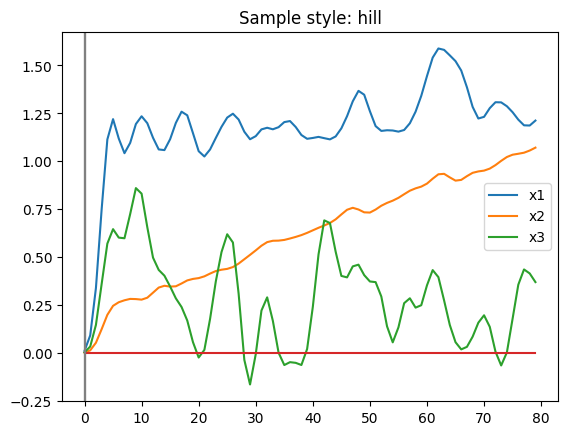

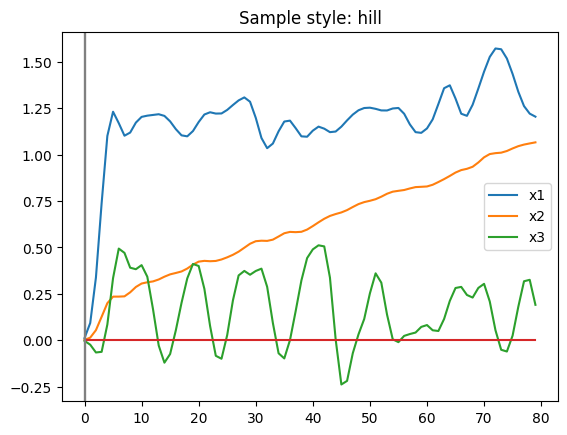

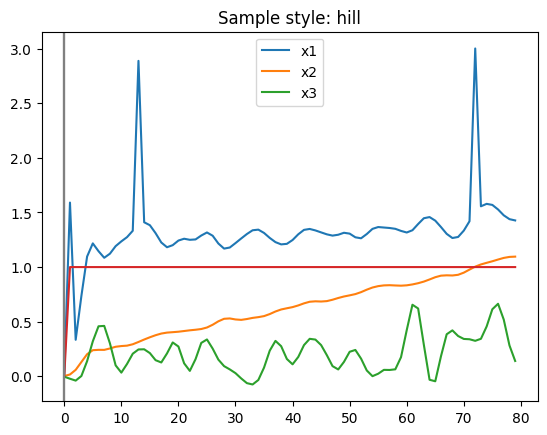

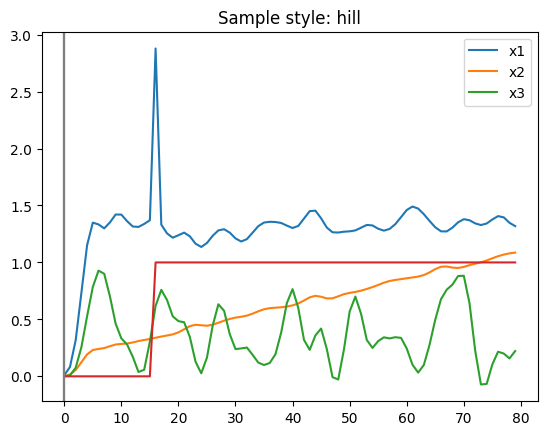

In [9]:

ground_truth_importance_train = np.array(ground_truth_importance_train)
ground_truth_importance_test = np.array(ground_truth_importance_test)

ground_truth_imp_train_mat = np.zeros((n_train,3,Tt))
ground_truth_imp_test_mat = np.zeros((n_test,3,Tt))

ground_truth_imp_train_mat[:,0,:] = ground_truth_importance_train
ground_truth_imp_test_mat[:,0,:] = ground_truth_importance_test

if plot:
    for i in range(10):# x_train_n.shape[0]):
        plt.plot(x_train_n[i,0,:], label='x1')
        plt.plot(x_train_n[i,1,:], label='x2')
        plt.plot(x_train_n[i,2,:], label='x3')
        plt.plot(y_train[i,:])
        #plt.ylim([-5,5])
        plt.title('Sample style: %s'%(trend_style[i]))

        if isinstance(thresholds[i],np.ndarray):
            for thresh in thresholds[i]:
                plt.axvline(x=thresh, color='grey')
        else:
            plt.axvline(x=thresholds[i], color='grey')

        plt.legend()
        plt.show()

